### Importing Libraries

In [1]:
#Generic Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
from PIL import Image
import pandas as pd
import numpy as np

#Apache Spark Libraries
from pyspark.sql import SparkSession, Row
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql import functions as F
from pyspark.sql import types as T

from pyspark.sql.functions import *
# sklearn Libraries
import sklearn
from sklearn.model_selection import train_test_split

In [2]:
spark = SparkSession.builder.appName('AcidSoils').getOrCreate()
source = gpd.read_file("/Users/tamiratatsemegiorgis/project/data/GTK_ASsoil_obs.csv")
source.head(4)

23/03/02 11:27:17 WARN Utils: Your hostname, tamirats-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.31.180 instead (on interface en0)
23/03/02 11:27:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/02 11:27:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/03/02 11:27:18 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


,POINT_X,POINT_Y,CLASS,geometry
0,441468.7125,7184281.005,ASS,None
1,441852.3101,7186002.327,ASS,None
2,442236.5012,7185249.359,ASS,None
3,420520.3581,7208257.978,ASS,None


In [3]:
source= source.drop("geometry", axis=1)
source

,POINT_X,POINT_Y,CLASS
0,441468.7125,7184281.005,ASS
1,441852.3101,7186002.327,ASS
2,442236.5012,7185249.359,ASS
3,420520.3581,7208257.978,ASS
4,421346.5424,7186579.062,ASS
...,...,...,...
5819,431075.1332,7280742.189,ASS
5820,424970.7877,7279012.794,non-ASS
5821,424990.7372,7279053.719,non-ASS
5822,423466.8499,7274347.804,ASS


In [4]:
geom = gpd.points_from_xy(source.POINT_X.astype("float"), source.POINT_Y.astype("float"))
points = gpd.GeoDataFrame(source.CLASS, crs="EPSG:3067", geometry=geom).to_crs("WGS84")
points.head(4)

,CLASS,geometry
0,ASS,POINT (25.76894 64.77799)
1,ASS,POINT (25.77630 64.79350)
2,ASS,POINT (25.78469 64.78681)
3,ASS,POINT (25.31512 64.98873)


In [5]:
points["x"] = points.geometry.x
points["y"] = points.geometry.y

points.head(4)

,CLASS,geometry,x,y
0,ASS,POINT (25.76894 64.77799),25.768938,64.777988
1,ASS,POINT (25.77630 64.79350),25.776304,64.793496
2,ASS,POINT (25.78469 64.78681),25.784691,64.786808
3,ASS,POINT (25.31512 64.98873),25.315115,64.988732


In [6]:
df = spark.createDataFrame(points)
df.show(4,truncate=False)

+-----+---------------------------+------------------+-----------------+
|CLASS|geometry                   |x                 |y                |
+-----+---------------------------+------------------+-----------------+
|ASS  |{105553174674336, false, 2}|25.768937832725747|64.77798766173387|
|ASS  |{105553174721376, false, 2}|25.77630416654702 |64.79349633623737|
|ASS  |{105553174720608, false, 2}|25.784691167397362|64.7868078298281 |
|ASS  |{105553174721568, false, 2}|25.315115332474953|64.98873249710591|
+-----+---------------------------+------------------+-----------------+
only showing top 4 rows



In [7]:
df= (df.
    select(
        "geometry","x","y",
    (F.col("CLASS") == "ASS").astype("int").alias("class"),
    )
)
df.show(4,truncate=False)

+---------------------------+------------------+-----------------+-----+
|geometry                   |x                 |y                |class|
+---------------------------+------------------+-----------------+-----+
|{105553174674336, false, 2}|25.768937832725747|64.77798766173387|1    |
|{105553174721376, false, 2}|25.77630416654702 |64.79349633623737|1    |
|{105553174720608, false, 2}|25.784691167397362|64.7868078298281 |1    |
|{105553174721568, false, 2}|25.315115332474953|64.98873249710591|1    |
+---------------------------+------------------+-----------------+-----+
only showing top 4 rows



In [8]:
df.groupby('class').count().show()

+-----+-----+
|class|count|
+-----+-----+
|    1| 3490|
|    0| 2334|
+-----+-----+



## Add point ID

In [14]:
TILE_SIZE = 256

@F.udf(returnType=T.ArrayType(T.IntegerType()))
def project_pixel(lon, lat, zoom):
    # lon, lat = p.geometry.x, p.geometry.y
    
    siny = np.sin(lat * np.pi / 180)
    #siny = min(max(siny,-0.9999), 0.9999)
    
    x = TILE_SIZE * (0.5 + lon / 360)
    y = TILE_SIZE * (0.5 - np.log((1 + siny) / (1 - siny)) / (4 * np.pi))
    
    scale = 2**zoom

    tx = x * scale // TILE_SIZE
    ty = y * scale // TILE_SIZE

    px = x * scale % TILE_SIZE // 1
    py = y * scale % TILE_SIZE // 1

    return [int(px), int(py)]

        
@F.udf(returnType=T.ArrayType(T.IntegerType()))
def project_tile(lon, lat, zoom):
    
    siny = np.sin(lat * np.pi / 180)
    #siny = min(max(siny,-0.9999), 0.9999)
    
    x = TILE_SIZE * (0.5 + lon / 360)
    y = TILE_SIZE * (0.5 - np.log((1 + siny) / (1 - siny)) / (4 * np.pi))
    
    scale = 2**zoom

    tx = x * scale // TILE_SIZE
    ty = y * scale // TILE_SIZE

    px = x * scale % TILE_SIZE // 1
    py = y * scale % TILE_SIZE // 1

    return [int(zoom), int(tx), int(ty)]

In [15]:
#for zoom = 8
df_points8 = (
    df
    .withColumn("pixel8", project_pixel(df.x, df.y, F.lit(8)))
    .withColumn("tile8", project_tile(df.x, df.y, F.lit(8)))
    .withColumn("point_id", F.monotonically_increasing_id())
    .drop("x", "y", "geometry")
    
)
df_points8.show()

+-----+---------+------------+--------+
|class|   pixel8|       tile8|point_id|
+-----+---------+------------+--------+
|    1|[83, 254]|[8, 146, 66]|       0|
|    1|[84, 247]|[8, 146, 66]|       1|
|    1|[85, 250]|[8, 146, 66]|       2|
|    1| [0, 163]|[8, 146, 66]|       3|
|    1| [5, 247]|[8, 146, 66]|       4|
|    1|[84, 228]|[8, 146, 66]|       5|
|    1|[59, 239]|[8, 146, 66]|       6|
|    1|[23, 244]|[8, 146, 66]|       7|
|    1|[226, 63]|[8, 145, 67]|       8|
|    1|[227, 65]|[8, 145, 67]|       9|
|    1|[236, 69]|[8, 145, 67]|      10|
|    1|[238, 76]|[8, 145, 67]|      11|
|    1|[216, 55]|[8, 145, 67]|      12|
|    1|[226, 45]|[8, 145, 67]|      13|
|    1|[223, 45]|[8, 145, 67]|      14|
|    1|[221, 44]|[8, 145, 67]|      15|
|    1|[222, 56]|[8, 145, 67]|      16|
|    1|[222, 50]|[8, 145, 67]|      17|
|    1|[224, 62]|[8, 145, 67]|      18|
|    1|[229, 57]|[8, 145, 67]|      19|
+-----+---------+------------+--------+
only showing top 20 rows



In [16]:
#for zoom = 9
df_points9 = (
    df
    .withColumn("pixel9", project_pixel(df.x, df.y, F.lit(9)))
    .withColumn("tile9", project_tile(df.x, df.y,F.lit(9)))
    .withColumn("point_id", F.monotonically_increasing_id())
    .drop("x", "y", "geometry")
)
df_points9.show(4)

+-----+----------+-------------+--------+
|class|    pixel9|        tile9|point_id|
+-----+----------+-------------+--------+
|    1|[166, 252]|[9, 292, 133]|       0|
|    1|[168, 239]|[9, 292, 133]|       1|
|    1|[171, 245]|[9, 292, 133]|       2|
|    1|   [0, 71]|[9, 292, 133]|       3|
+-----+----------+-------------+--------+
only showing top 4 rows



In [17]:
#for zoom = 10
df_points10 = (
    df

    .withColumn("pixel10", project_pixel(df.x, df.y, F.lit(10)))
    .withColumn("tile10", project_tile(df.x, df.y,F.lit(10)))
    .withColumn("point_id", F.monotonically_increasing_id())
    .drop("x", "y", "geometry")
    
)

df_points10.show(4)


+-----+---------+--------------+--------+
|class|  pixel10|        tile10|point_id|
+-----+---------+--------------+--------+
|    1|[76, 249]|[10, 585, 267]|       0|
|    1|[81, 222]|[10, 585, 267]|       1|
|    1|[87, 234]|[10, 585, 267]|       2|
|    1| [1, 143]|[10, 584, 266]|       3|
+-----+---------+--------------+--------+
only showing top 4 rows



## Combine output class with pixel coordinates

In [77]:
TILES_BASIC = "/Users/tamiratatsemegiorgis/project/data/earlerData/MapTilesViewer/basic/{z}/{x}/{y}.png"
TILES_HILLSHADE ="/Users/tamiratatsemegiorgis/project/data/earlerData/TILES_hillshade/{z}/{x}/{y}.png"

@F.udf(returnType=T.ArrayType(T.ArrayType(T.LongType())))
def load_image_data(tile, pixel_data, tiles):
    """
    tiles: folder with tiles
    """
    (z, tx, ty) = tile
    
    fname = tiles.format(z=z, x=tx, y=ty)
    try :
        im = Image.open(fname)
        arr_img= np.array(im)

        data = []
        for i, j, pid in pixel_data:
            if arr_img.shape[-1] == 3:
                # color image
                r, g, b = arr_img[i, j] # 3 dim array, ?
                data.append([int(r), int(g), int(b), pid])
            else:
                # grayscale image
                gray, alpha = arr_img[i, j]
                data.append([int(gray), pid])

        return data
    except :
        print("")

In [78]:
def func1(p,TILES):
    
    a1=p.columns[1]
    a2 = p.columns[2]
    p=p.withColumnRenamed(a1, "pixel")
    p=p.withColumnRenamed(a2, "tile")
    df_basic_raw = (
        p
        .select(
            "point_id", "pixel", "tile",
        )
        .withColumn("pixel_i", F.col("pixel")[0])
        .withColumn("pixel_j", F.col("pixel")[1])
        .withColumn("pixel_data", F.array(F.col("pixel_i"), F.col("pixel_j"), F.col("point_id")))

        # processing
        .groupby("tile")
        .agg(
            F.collect_list("pixel_data").alias("pixel_data_list"),
        )
        .withColumn("data_basic", load_image_data(F.col("tile"), F.col("pixel_data_list"),
                                                  F.lit(TILES)))

        .select(F.explode("data_basic").alias("data"))
        
            .select(
                F.col("data")[0].alias("basic_r"),
                F.col("data")[1].alias("basic_g"),
                F.col("data")[2].alias("basic_b"),
                F.col("data")[3].alias("point_id"),     
            )
         
            # put back points class
        .join(
             p.select("CLASS", "point_id"),     on="point_id",
            ) 
    )
    return df_basic_raw

    

### For zoom level 8

In [80]:
from pyspark.sql.functions import *
df_basic_raw8=func1(df_points8, TILES_BASIC)
df_basic_raw8=(df_basic_raw8.select("point_id",
    col("basic_r").alias("basic_r8"),
    col("basic_g").alias("basic_g8"),
    col("basic_b").alias("basic_b8"),
    "CLASS"
))
df_basic_raw8.show(2)

+--------+--------+--------+--------+-----+
|point_id|basic_r8|basic_g8|basic_b8|CLASS|
+--------+--------+--------+--------+-----+
|      26|      61|      77|      48|    1|
|      29|      87|      96|      65|    1|
+--------+--------+--------+--------+-----+
only showing top 2 rows



 ## For zoom level 9

In [81]:
from pyspark.sql.functions import *
df_basic_raw9=func1(df_points9,TILES_BASIC)
df_basic_raw9=(df_basic_raw9.select("point_id",
    col("basic_r").alias("basic_r9"),
    col("basic_g").alias("basic_g9"),
    col("basic_b").alias("basic_b9"),
    "CLASS"
))
df_basic_raw9.show(2)



+--------+--------+--------+--------+-----+
|point_id|basic_r9|basic_g9|basic_b9|CLASS|
+--------+--------+--------+--------+-----+
|      26|     118|     111|      95|    1|
|      29|     107|     102|      82|    1|
+--------+--------+--------+--------+-----+
only showing top 2 rows



 ## For zoom level 10

In [82]:
df_points10.show(2)

+-----+---------+--------------+--------+
|class|  pixel10|        tile10|point_id|
+-----+---------+--------------+--------+
|    1|[76, 249]|[10, 585, 267]|       0|
|    1|[81, 222]|[10, 585, 267]|       1|
+-----+---------+--------------+--------+
only showing top 2 rows



In [83]:

df_basic_raw10=func1(df_points10,TILES_BASIC)
df_basic_raw10=(df_basic_raw10.select("point_id",
    col("basic_r").alias("basic_r10"),
    col("basic_g").alias("basic_g10"),
    col("basic_b").alias("basic_b10"),
    "CLASS"
))
df_basic_raw10.show(2)

+--------+---------+---------+---------+-----+
|point_id|basic_r10|basic_g10|basic_b10|CLASS|
+--------+---------+---------+---------+-----+
|      26|       51|       69|       31|    1|
|      29|       79|      100|       59|    1|
+--------+---------+---------+---------+-----+
only showing top 2 rows



In [84]:
#df1=df_basic_raw10.filter(df_basic_raw10.point_id ==459 )
#df1.show()

In [85]:
 # Join pyspark datasets for zoom 8,9 and 10
sp_df_data_raw_8_9_10 = (
    df_basic_raw8.drop("CLASS")
    .join(df_basic_raw9.drop("CLASS"), on="point_id")
     .join(df_basic_raw10, on="point_id")
)
sp_df_data_raw_8_9_10.show(4)

+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+-----+
|point_id|basic_r8|basic_g8|basic_b8|basic_r9|basic_g9|basic_b9|basic_r10|basic_g10|basic_b10|CLASS|
+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+-----+
|       0|     100|     114|      78|     107|     101|      75|      106|       92|       66|    1|
|       1|     115|     122|      88|      81|     102|      69|       70|       81|       47|    1|
|       2|      99|     103|      70|      85|      95|      61|       80|       87|       56|    1|
|       3|      81|      97|      61|     104|     114|      90|       60|       79|       51|    1|
+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+-----+
only showing top 4 rows



In [86]:
#check the CLASS column
sp_df_data_raw_8_9_10.groupby('CLASS').count().show()

+-----+-----+
|CLASS|count|
+-----+-----+
|    1| 3490|
|    0| 2334|
+-----+-----+



In [87]:
sp_df_data_raw_8_9_10.printSchema()

root
 |-- point_id: long (nullable = true)
 |-- basic_r8: long (nullable = true)
 |-- basic_g8: long (nullable = true)
 |-- basic_b8: long (nullable = true)
 |-- basic_r9: long (nullable = true)
 |-- basic_g9: long (nullable = true)
 |-- basic_b9: long (nullable = true)
 |-- basic_r10: long (nullable = true)
 |-- basic_g10: long (nullable = true)
 |-- basic_b10: long (nullable = true)
 |-- CLASS: integer (nullable = true)



## Model building and Testing using  Using Sk-learn

In [88]:
#convert the pyspark dataframe to pandas dataframe
df_data_basicMap_8_9_10=sp_df_data_raw_8_9_10.toPandas().set_index('point_id')
df_data_basicMap_8_9_10

,basic_r8,basic_g8,basic_b8,basic_r9,basic_g9,basic_b9,basic_r10,basic_g10,basic_b10,CLASS
point_id,,,,,,,,,,
0,100,114,78,107,101,75,106,92,66,1
1,115,122,88,81,102,69,70,81,47,1
2,99,103,70,85,95,61,80,87,56,1
3,81,97,61,104,114,90,60,79,51,1
4,131,139,102,157,165,126,56,56,30,1
...,...,...,...,...,...,...,...,...,...,...
60129542867,108,115,81,121,98,67,143,122,93,1
60129542868,95,111,72,109,118,87,87,98,64,0
60129542869,95,111,72,109,118,87,87,98,64,0


In [89]:
# create independent featur X and label column y
X= df_data_basicMap_8_9_10.iloc[:,1:10].values
y=df_data_basicMap_8_9_10.iloc[:,-1].values
X

array([[114,  78, 107, ...,  92,  66,   1],
       [122,  88,  81, ...,  81,  47,   1],
       [103,  70,  85, ...,  87,  56,   1],
       ...,
       [111,  72, 109, ...,  98,  64,   0],
       [130,  97, 173, ..., 182, 145,   1],
       [ 37,  48,   8, ...,  38,  52,   1]])

In [90]:
#split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33,random_state=0)
X_train.shape

(3902, 9)

In [91]:
aspect_10m="/Users/tamiratatsemegiorgis/project/data/newData/elev_10m_aspect/{z}/{x}/{y}.png"
hillshade_10m="/Users/tamiratatsemegiorgis/project/data/newData/elev_10m_hillshade/{z}/{x}/{y}.png"
slope_10m="/Users/tamiratatsemegiorgis/project/data/newData/elev_10m_slope/{z}/{x}/{y}.png"
corine_land = "/Users/tamiratatsemegiorgis/project/data/newData/corine_land_cover/{z}/{x}/{y}.png"

In [92]:
def func2(p, tiles):
    a1=p.columns[1]
    a2 = p.columns[2]
    p=p.withColumnRenamed(a1, "pixel")
    p=p.withColumnRenamed(a2, "tile")
    df_hill_raw8 = (
        p
        .select(
            "point_id", "pixel", "tile",
        )
        .withColumn("pixel_i", F.col("pixel")[0])
        .withColumn("pixel_j", F.col("pixel")[1])
        .withColumn("pixel_data", F.array(F.col("pixel_i"), F.col("pixel_j"), F.col("point_id")))

        .groupby("tile")
        .agg(
            F.collect_list("pixel_data").alias("pixel_data_list"),
        )

        .withColumn("data_basic", load_image_data(F.col("tile"), F.col("pixel_data_list"),
                                                   F.lit(tiles)))

        .withColumn("data", F.explode("data_basic"))
        .select(
            F.col("data")[0].alias("basic_r"),
    #         F.col("data")[1].alias("basic_g8"),
    #         F.col("data")[2].alias("basic_b8"),
            F.col("data")[1].alias("point_id"),     
        )

        # put back points class
        .join(
            p.select("CLASS", "point_id"),     on="point_id",
        )     



    )
    return df_hill_raw8

## corine_land for zoom 8,9,10

In [93]:
from pyspark.sql.functions import *
df_corine_land_row8=func2(df_points8,corine_land)
df_corine_land_row8=(df_corine_land_row8.select("point_id",
    col("basic_r").alias("cor8"),
    "CLASS"
))
df_corine_land_row8.show(2)

+--------+----+-----+
|point_id|cor8|CLASS|
+--------+----+-----+
|      26|  17|    1|
|      29|  25|    1|
+--------+----+-----+
only showing top 2 rows



In [96]:
#image 9/293/130 is not there,(there is 128,131,...148) i copied 128 and rename it to 130,to pass 

df_corine_land_row9=func2(df_points9,corine_land)
df_corine_land_row9=(df_corine_land_row9.select("point_id",
    col("basic_r").alias("cor9"),
    "CLASS"
))
df_corine_land_row9.show(2)

+--------+----+-----+
|point_id|cor9|CLASS|
+--------+----+-----+
|      26|  35|    1|
|      29|  25|    1|
+--------+----+-----+
only showing top 2 rows



In [97]:
#image 10/586/261 is not there,(there is 256,257,262, 263...) i copied 257 and rename it to 261, 
#then error message went
df_corine_land_row10=func2(df_points10,corine_land)
df_corine_land_row10=(df_corine_land_row10.select("point_id",
    col("basic_r").alias("cor10"),
    "CLASS"
))
df_corine_land_row10.show(2)

+--------+-----+-----+
|point_id|cor10|CLASS|
+--------+-----+-----+
|      26|   28|    1|
|      29|   29|    1|
+--------+-----+-----+
only showing top 2 rows



In [98]:
 # Join corine pyspark datasets for zoom 8,9 and 10
df_corine_marge_8_9_10 = (
    df_corine_land_row8.drop("CLASS")
    .join(df_corine_land_row9.drop("CLASS"), on="point_id")
     .join(df_corine_land_row10, on="point_id")
)
df_corine_marge_8_9_10.show(2)

+--------+----+----+-----+-----+
|point_id|cor8|cor9|cor10|CLASS|
+--------+----+----+-----+-----+
|       0|  26|  43|   26|    1|
|       1|  43|  34|   34|    1|
+--------+----+----+-----+-----+
only showing top 2 rows



In [99]:
print(df_corine_marge_8_9_10.dropDuplicates(["cor8"]).select("cor8").count())

37


In [100]:
#convert the pyspark dataframe to pandas dataframe
corine8_9_10=df_corine_marge_8_9_10.toPandas()
corine8_9_10p=corine8_9_10.set_index('point_id')

In [101]:
corine8_9_10p.head(2)

,cor8,cor9,cor10,CLASS
point_id,,,,
0,26,43,26,1
1,43,34,34,1


In [102]:
corine8_9_10_dummies=pd.get_dummies(data=corine8_9_10p, columns=['cor8', 'cor9', 'cor10'])


In [103]:
corine8_9_10_dummies

,CLASS,cor8_1,cor8_2,cor8_3,cor8_4,cor8_5,cor8_6,cor8_7,cor8_8,cor8_10,...,cor10_41,cor10_42,cor10_43,cor10_44,cor10_45,cor10_46,cor10_47,cor10_48,cor10_49,cor10_255
point_id,,,,,,,,,,,,,,,,,,,,,
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60129542867,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
60129542868,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60129542869,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Hillside for zoom 8,9,10

In [104]:
from pyspark.sql.functions import *
df_hillshade_10m_row8=func2(df_points8,hillshade_10m)
df_hillshade_10m_row8=(df_hillshade_10m_row8.select("point_id",
    col("basic_r").alias("hil8"),
    "CLASS"
))
df_hillshade_10m_row8.show(2)

+--------+----+-----+
|point_id|hil8|CLASS|
+--------+----+-----+
|      26| 196|    1|
|      29| 196|    1|
+--------+----+-----+
only showing top 2 rows



In [135]:
df_hillshade_10m_row9=func2(df_points9,hillshade_10m)
df_hillshade_10m_row9=(df_hillshade_10m_row9.select("point_id",
    col("basic_r").alias("hil9"),
    "CLASS"
))
df_hillshade_10m_row9.show(2)

+--------+----+-----+
|point_id|hil9|CLASS|
+--------+----+-----+
|      26| 196|    1|
|      29| 197|    1|
+--------+----+-----+
only showing top 2 rows



In [106]:
#df_hillshade_10m_row8.groupby('CLASS').count().show()

In [136]:
df_hillshade_10m_row10=func2(df_points10,hillshade_10m)
df_hillshade_10m_row10=(df_hillshade_10m_row10.select("point_id",
    col("basic_r").alias("hil10"),
    "CLASS"
))
df_hillshade_10m_row10.show(2)

+--------+-----+-----+
|point_id|hil10|CLASS|
+--------+-----+-----+
|      26|  196|    1|
|      29|  197|    1|
+--------+-----+-----+
only showing top 2 rows



In [108]:
 # Join hillshade pyspark datasets for zoom 8,9 and 10
df_hillshade_10m_marge_8_9_10 = (
    df_hillshade_10m_row8.drop("CLASS")
    .join(df_hillshade_10m_row9.drop("CLASS"), on="point_id")
     .join(df_hillshade_10m_row10, on="point_id")
)
df_hillshade_10m_marge_8_9_10.show(2)

+--------+----+----+-----+-----+
|point_id|hil8|hil9|hil10|CLASS|
+--------+----+----+-----+-----+
|       0| 196| 196|  196|    1|
|       1| 196| 197|  196|    1|
+--------+----+----+-----+-----+
only showing top 2 rows



In [109]:
#df_hillshade_10m_marge_8_9_10.groupby("hil8").count().show()

## Aspect

In [110]:
df_aspect_10m_row8=func2(df_points8,aspect_10m)
df_aspect_10m_row8=(df_aspect_10m_row8.select("point_id",
    col("basic_r").alias("asp8"),
    "CLASS"
))
df_aspect_10m_row8.show(2)

+--------+----+-----+
|point_id|asp8|CLASS|
+--------+----+-----+
|      26|  79|    1|
|      29| 129|    1|
+--------+----+-----+
only showing top 2 rows



In [138]:

df_aspect_10m_row9=func2(df_points9,aspect_10m)
df_aspect_10m_row9=(df_aspect_10m_row9.select("point_id",
    col("basic_r").alias("asp9"),
    "CLASS"
))
df_aspect_10m_row9.show()

+--------+----+-----+
|point_id|asp9|CLASS|
+--------+----+-----+
|      26|  99|    1|
|      29|  97|    1|
|     474| 117|    1|
|      65| 143|    1|
|     191|  80|    1|
|     418| 128|    1|
|     541|  52|    1|
|     558| 156|    1|
|     222| 100|    1|
|     270| 106|    1|
|     293| 152|    1|
|     243|  79|    1|
|     278| 151|    1|
|     367|  31|    1|
|     442| 134|    1|
|     705| 176|    1|
|     720| 161|    1|
|      19|  35|    1|
|      54| 129|    1|
|     296| 127|    1|
+--------+----+-----+
only showing top 20 rows



In [139]:
df_aspect_10m_row10=func2(df_points10,aspect_10m)
df_aspect_10m_row10=(df_aspect_10m_row10.select("point_id",
    col("basic_r").alias("asp10"),
    "CLASS"
))
df_aspect_10m_row10.show(2)

+--------+-----+-----+
|point_id|asp10|CLASS|
+--------+-----+-----+
|      26|   62|    1|
|      29|   67|    1|
+--------+-----+-----+
only showing top 2 rows



In [140]:
df_aspect_10m_marge_8_9_10 = (
    df_aspect_10m_row8.drop("CLASS")
    .join(df_aspect_10m_row9.drop("CLASS"), on="point_id")
     .join(df_aspect_10m_row10, on="point_id")
)
df_aspect_10m_marge_8_9_10.show(2)

+--------+----+----+-----+-----+
|point_id|asp8|asp9|asp10|CLASS|
+--------+----+----+-----+-----+
|       0| 112| 133|  129|    1|
|       1| 122| 152|  121|    1|
+--------+----+----+-----+-----+
only showing top 2 rows



## Slope

In [114]:
df_slope_10m_row8=func2(df_points8,slope_10m)
df_slope_10m_row8=(df_slope_10m_row8.select("point_id",
    col("basic_r").alias("slp8"),
    "CLASS"
))
df_slope_10m_row8.show(2)

+--------+----+-----+
|point_id|slp8|CLASS|
+--------+----+-----+
|      26| 254|    1|
|      29| 254|    1|
+--------+----+-----+
only showing top 2 rows



In [141]:
df_slope_10m_row9=func2(df_points9,slope_10m)
df_slope_10m_row9=(df_slope_10m_row9.select("point_id",
    col("basic_r").alias("slp9"),
    "CLASS"
))
df_slope_10m_row9.show(2)

+--------+----+-----+
|point_id|slp9|CLASS|
+--------+----+-----+
|      26| 255|    1|
|      29| 254|    1|
+--------+----+-----+
only showing top 2 rows



In [143]:
df_slope_10m_row10=func2(df_points10,slope_10m)
df_slope_10m_row10=(df_slope_10m_row10.select("point_id",
    col("basic_r").alias("slp10"),
    "CLASS"
))
df_slope_10m_row10.show(2)

+--------+-----+-----+
|point_id|slp10|CLASS|
+--------+-----+-----+
|      26|  255|    1|
|      29|  255|    1|
+--------+-----+-----+
only showing top 2 rows



In [147]:
df_slope_10m_row10.groupby("slp10").count().show()

+-----+-----+
|slp10|count|
+-----+-----+
|  243|   31|
|  241|   14|
|  237|    6|
|  196|    2|
|  232|    2|
|  255| 3013|
|  239|    8|
|  234|    5|
|  253|  564|
|  236|    6|
|  246|   39|
|  242|   14|
|  248|   95|
|  235|    2|
|  250|  165|
|  214|    1|
|  252|  391|
|  224|    1|
|  254|  972|
|  247|   67|
+-----+-----+
only showing top 20 rows



In [117]:
 # Join slope pyspark datasets for zoom 8,9 and 10
df_slope_10m_marge_8_9_10 = (
    df_slope_10m_row8.drop("CLASS")
    .join(df_slope_10m_row9.drop("CLASS"), on="point_id")
     .join(df_slope_10m_row10, on="point_id")
)
df_slope_10m_marge_8_9_10.show(2)

+--------+----+----+-----+-----+
|point_id|slp8|slp9|slp10|CLASS|
+--------+----+----+-----+-----+
|       0| 254| 255|  255|    1|
|       1| 255| 254|  255|    1|
+--------+----+----+-----+-----+
only showing top 2 rows



In [118]:
#df_slope_10m_marge_8_9_10.groupby("slp8").count().show()

# Merge slope, corine, hillside, aspec

In [145]:
 # Join slope pyspark datasets for zoom 8,9 and 10
df_marge_hil_asp_slo_marge_8_9_10 = (
    
    df_hillshade_10m_marge_8_9_10.drop("CLASS")
    .join(df_aspect_10m_marge_8_9_10.drop("CLASS"), on="point_id") 
    .join(df_slope_10m_marge_8_9_10.drop("CLASS"), on="point_id")
)
df_marge_hil_asp_slo_marge_8_9_10.show()

+--------+----+----+-----+----+----+-----+----+----+-----+
|point_id|hil8|hil9|hil10|asp8|asp9|asp10|slp8|slp9|slp10|
+--------+----+----+-----+----+----+-----+----+----+-----+
|       0| 196| 196|  196| 112| 133|  129| 254| 255|  255|
|       1| 196| 197|  196| 122| 152|  121| 255| 254|  255|
|       2| 196| 198|  198|  94| 160|  165| 255| 252|  253|
|       3| 195| 198|  198|  69| 155|   94| 255| 254|  254|
|       4| 198| 196|  197| 179| 117|  115| 254| 254|  255|
|       5| 196| 195|  195|  83|  86|  108| 255| 251|  252|
|       6| 197| 198|  197| 148|  37|  133| 253| 249|  254|
|       7| 196| 197|  197|  62|  85|  148| 255| 254|  253|
|       8| 197| 196|  197| 128|  76|  164| 255| 255|  255|
|       9| 200| 194|  196| 188|  75|   84| 253| 254|  254|
|      10| 196| 196|  196| 106|  67|   56| 255| 255|  255|
|      11| 196| 196|  197| 120|  83|  106| 254| 255|  255|
|      12| 197| 197|  197| 136|  56|  125| 254| 254|  255|
|      13| 198| 196|  197| 155|  78|  129| 252| 250|  25

In [120]:
df_marge_hil_asp_slo_marge_8_9_10p=df_marge_hil_asp_slo_marge_8_9_10.toPandas()
df_marge_hil_asp_slo_marge_8_9_10p=df_marge_hil_asp_slo_marge_8_9_10p.set_index('point_id')

In [121]:
df_marge_hil_asp_slo_marge_8_9_10p

,hil8,hil9,hil10,asp8,asp9,asp10,slp8,slp9,slp10
point_id,,,,,,,,,
0,196,196,196,112,133,129,254,255,255
1,196,197,196,122,152,121,255,254,255
2,196,198,198,94,160,165,255,252,253
3,195,198,198,69,155,94,255,254,254
4,198,196,197,179,117,115,254,254,255
...,...,...,...,...,...,...,...,...,...
60129542867,195,197,197,56,152,155,253,255,254
60129542868,196,199,199,36,173,170,253,253,253
60129542869,196,199,199,36,173,170,253,253,253


In [122]:

df_marge_cor_hil_asp_slo_marge_8_9_10p=pd.merge(df_marge_hil_asp_slo_marge_8_9_10p,corine8_9_10_dummies, left_index=True, right_index=True)

#df_marge_cor_hil_asp_slo_marge_8_9_10p

In [123]:
df_data_basicMap_8_9_10=df_data_basicMap_8_9_10.drop("CLASS", axis=1)
#df_data_basicMap_8_9_10

In [124]:
df_marge_basic_cor_hil_asp_slo_marge_8_9_10p=pd.merge(df_data_basicMap_8_9_10,df_marge_cor_hil_asp_slo_marge_8_9_10p, left_index=True, right_index=True)

df_marge_basic_cor_hil_asp_slo_marge_8_9_10p

,basic_r8,basic_g8,basic_b8,basic_r9,basic_g9,basic_b9,basic_r10,basic_g10,basic_b10,hil8,...,cor10_41,cor10_42,cor10_43,cor10_44,cor10_45,cor10_46,cor10_47,cor10_48,cor10_49,cor10_255
point_id,,,,,,,,,,,,,,,,,,,,,
0,100,114,78,107,101,75,106,92,66,196,...,0,0,0,0,0,0,0,0,0,0
1,115,122,88,81,102,69,70,81,47,196,...,0,0,0,0,0,0,0,0,0,0
2,99,103,70,85,95,61,80,87,56,196,...,0,0,0,0,0,0,0,0,0,0
3,81,97,61,104,114,90,60,79,51,195,...,0,0,0,0,0,0,0,0,0,0
4,131,139,102,157,165,126,56,56,30,198,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60129542867,108,115,81,121,98,67,143,122,93,195,...,0,0,0,1,0,0,0,0,0,0
60129542868,95,111,72,109,118,87,87,98,64,196,...,0,0,0,0,0,0,0,0,0,0
60129542869,95,111,72,109,118,87,87,98,64,196,...,0,0,0,0,0,0,0,0,0,0


In [125]:
# create independent featur X and label column y
y= df_marge_basic_cor_hil_asp_slo_marge_8_9_10p["CLASS"].values
X=df_marge_basic_cor_hil_asp_slo_marge_8_9_10p.drop("CLASS", axis=1).values

In [126]:
#split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33,random_state=0)
X_train.shape

(3900, 133)

In [127]:
#using Rendomiz search with cv = 5
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform 
from scipy.stats import randint

rfc = RandomForestClassifier(criterion = 'entropy', class_weight = 'balanced')
param_dist = {"max_depth" : randint(1,10),
              "n_estimators" :randint(2,1000),
              "max_features" :randint(1,20)}
n_iter_search = 50
start=time.time()

random_search = RandomizedSearchCV(rfc, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, 
                                   n_jobs=-1, verbose=2, scoring='roc_auc')
search = random_search.fit(X_train, y_train)
print(f'Time: {time.time() - start}')

print("Summary of Results")
print(" ")
print("Best score: {}".format(search.best_score_))
print(" ")
print("Best parameters: {}".format(search.best_params_))
print(" ")
print("Best parameters: {}".format(search.scorer_))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Time: 76.84501600265503
Summary of Results
 
Best score: 0.6068761690184474
 
Best parameters: {'max_depth': 9, 'max_features': 1, 'n_estimators': 546}
 
Best parameters: make_scorer(roc_auc_score, needs_threshold=True)


In [128]:
from sklearn.metrics import accuracy_score
y_pred = search.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
test_acc

0.5822060353798127

In [129]:
print("The Accuracy for Test Set is {}".format(test_acc*100))

The Accuracy for Test Set is 58.220603537981276


Text(0.5, 33.0, 'Predicted Values')

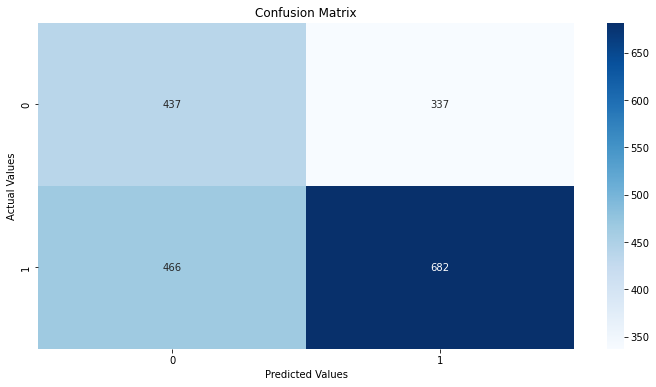

In [130]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred)
plt.figure(figsize=(12,6))
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True,fmt="d", cmap='Blues')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")

In [131]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge

In [132]:
std_slc = StandardScaler()
logistic_Reg = LogisticRegression(solver='liblinear',)

pipe = Pipeline(steps=[('std_slc', std_slc),
                           ('logistic_Reg', logistic_Reg)])

C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2']

parameters = dict(logistic_Reg__C=C,
                    logistic_Reg__penalty=penalty)


clf_GS = GridSearchCV(pipe, parameters,cv=5, n_jobs=2)
clf_GS.fit(X_train, y_train)

#print('Best Penalty:', clf_GS.best_estimator_.get_params()['logistic_Reg__penalty'])
#print('Best C:', clf_GS.best_estimator_.get_params()['logistic_Reg__C'])
#print(); print(clf_GS.best_estimator_.get_params()['logistic_Reg'])

[CV] END .....max_depth=3, max_features=12, n_estimators=396; total time=   1.5s
[CV] END .....max_depth=9, max_features=15, n_estimators=802; total time=   5.9s
[CV] END .....max_depth=8, max_features=19, n_estimators=663; total time=   4.9s
[CV] END ......max_depth=1, max_features=9, n_estimators=232; total time=   0.7s
[CV] END ......max_depth=1, max_features=4, n_estimators=318; total time=   0.9s
[CV] END ......max_depth=1, max_features=5, n_estimators=624; total time=   1.7s
[CV] END ......max_depth=7, max_features=7, n_estimators=286; total time=   1.3s
[CV] END ......max_depth=3, max_features=4, n_estimators=444; total time=   1.4s
[CV] END .....max_depth=2, max_features=17, n_estimators=563; total time=   2.1s
[CV] END .....max_depth=9, max_features=10, n_estimators=512; total time=   3.2s
[CV] END ......max_depth=4, max_features=6, n_estimators=661; total time=   2.7s
[CV] END .....max_depth=6, max_features=14, n_estimators=425; total time=   2.4s
[CV] END .....max_depth=7, m

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('std_slc', StandardScaler()),
                                       ('logistic_Reg',
                                        LogisticRegression(solver='liblinear'))]),
             n_jobs=2,
             param_grid={'logistic_Reg__C': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.250551...
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                         'logistic_Reg__penalty': ['l1', 'l2']})

In [133]:
y_predL = clf_GS.predict(X_test)

In [134]:
print("Test set score: {:.2f}".format(clf_GS.score(X_test, y_test)))
print("Train set score: {}".format(clf_GS.score(X_train, y_train)))

Test set score: 0.60
Train set score: 0.6233333333333333
